<a href="https://colab.research.google.com/github/millergw/cs181-s23-homeworks/blob/main/Introduction_to_Neural_Networks_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to PyTorch
### CS181
### Spring 2023
![](https://i.imgur.com/xDR9VQd.png)

**About:** This notebook will introduce you to a popular and powerful python library for deep learning called [PyTorch](https://pytorch.org/). Pytorch will allow you to 
1. specify a **model** (e.g. linear regression, logistic regression, neural network, etc.)
2. specify a **loss function** (i.e. a metric that quantifies "how well" our model fits our data)
3. given data, **optimize** this loss function relative to our model (i.e. to fit the model to the data by finding a model that minimizes the loss function). 

**Agenda:**
1. Tensors: We'll start by introducing PyTorch's `tensor`, the data structure PyTorch is built on. 
2. Loss functions & optimizers: Using these tensors, we'll show you how to specify loss functions and optimize them.
3. Putting it all together: We'll use everything covered in this tutorial to build and train a deep neural network. 

**Note:** This tutorial is not a comprehensive of everything available in the PyTorch library. Once you have a sense of what this library can do, we recommend you browse the [documentation](https://pytorch.org/docs/stable/index.html). 

In [ ]:
# Before we start, we have to import PyTorch:
import torch
import torch.nn as nn
import torch.optim as optim

# We'll also import some other helpful libraries
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import sklearn
import sklearn.datasets

## Part 1: Tensors

PyTorch is built on a data structure called a `tensor`. While it sounds fancy, it is in fact no different than any array-like data structure you have encountered so far in your CS courses. So if it's no different, why use it as opposed to other array-like data structures in Python? Because unlike other such data structures, in PyTorch, tensors will allow us to compute gradients and perform optimization -- we'll get to that in Part 2 of this tutorial. 

#### Creating tensors

So let's begin by specifying a tensor. We can do this in a number of ways:

In [ ]:
# We can create a tensor from a list:
a = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
print('A =', a)

# We can create a tensor from a numpy array:
b = torch.tensor(np.array([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]))
print('B =', b)

# We can create a tensor of random values with a size 2 by 2:
c = torch.randn((2, 2))
print('C =', c)

# We can create a tensor of ones with a size 1 by 1:
d = torch.ones((1, 1))
print('D =', d)

A = tensor([[1., 2., 3.],
        [4., 5., 6.]])
B = tensor([[1., 2., 3.],
        [4., 5., 6.]], dtype=torch.float64)
C = tensor([[ 0.3285,  0.7973],
        [-1.3326,  0.9980]])
D = tensor([[1.]])


We can also convert these PyTorch tensors back to numpy arrays or lists:

In [ ]:
print('A (as a numpy array) =', a.numpy())

print('B (as a list) =', a.tolist())

# When a tensor is 1x1, we can also get it from PyTorch as follows:
print('D (as a float) =', d.item())

A (as a numpy array) = [[1. 2. 3.]
 [4. 5. 6.]]
B (as a list) = [[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]]
D (as a float) = 1.0


Tensors generally have two properties: `shape` (describing how many elements are in the tensor) and `type` (describing whether the elements are floats, ints, etc.): 

In [ ]:
print('A.shape =', a.shape)
print('A.dtype =', a.dtype)

A.shape = torch.Size([2, 3])
A.dtype = torch.float32


#### Operating on tensors

Tensors can largely be operated on in the same way as numpy arrays (in case you're familiar with numpy).

In [ ]:
# One can index into a tensor as follows:
print('Entry (0, 1) of A =', a[0, 1])
print('Row 1 of A =', a[1])
print('')

# One can apply tensor-scalar operations, like multiplying or adding to a tensor by a constant:
print('3 * A =', 3.0 * a)
print('5 + A =', 5.0 + a)
print('')

# One can apply tensor-tensor operations:
print('Element-wise addition: A + A =', a + a)
print('Element-wise exponentiation: A^2 =', torch.pow(a, 2.0))
print('Matrix multiplication: A^T * A =', torch.mm(a.t(), a))

Entry (0, 1) of A = tensor(2.)
Row 1 of A = tensor([4., 5., 6.])

3 * A = tensor([[ 3.,  6.,  9.],
        [12., 15., 18.]])
5 + A = tensor([[ 6.,  7.,  8.],
        [ 9., 10., 11.]])

Element-wise addition: A + A = tensor([[ 2.,  4.,  6.],
        [ 8., 10., 12.]])
Element-wise exponentiation: A^2 = tensor([[ 1.,  4.,  9.],
        [16., 25., 36.]])
Matrix multiplication: A^T * A = tensor([[17., 22., 27.],
        [22., 29., 36.],
        [27., 36., 45.]])


...you get the idea. See the [documentation](https://pytorch.org/docs/stable/tensors.html) for a complete list of all operations, tensor types, etc.

Now that we know how to create and operate on tensors, we'll start using them to solve actual optimization problems.

## Part 2: Loss Functions and Optimization

We'll know show you how to specify arbitrary functions $f$ using tensors and minimize these functions relative to some set of parameters $W$:
$$
\min_W f(W)
$$
Later this tutorial, we'll show you how to make $f$ into a "loss function" for a model -- that is, to make $f$ evaluate "how well" our model fits the data.

We'll start by defining some function $f$, to be minimized. So long as $f$ accepts a tensor, and uses tensor operations to output a single-valued tensor, we'll be able to optimize $f$ (i.e. so long as $f: \mathbb{R}^D \rightarrow \mathbb{R}$).

Let's start with $f(w_0, w_1) = w_0^2 + 0.1 \cdot w_1^4$:

In [ ]:
def f(W):
    return torch.pow(W[0], 2.0) + 0.1 * torch.pow(W[1], 4.0)

Now that we defined $f$, let's defined $W$ in such a way that PyTorch will be able to optimize $f$ relative to it. We'll do this by creating $W$ as a `tensor`, and wrapping it by the PyTorch object `nn.Parameter` to let PyTorch know it's a parameter we'd like to optimize relative to:

In [ ]:
# Here we chose to initialize W to [1.0, 2.0].
# In practice we often initialize model parameters randomly.
# The "requires_grad" flag is set to enable optimization.
W = nn.Parameter(torch.tensor([1.0, 2.0]), requires_grad=True)

Lastly, we'll create an `optimizer`, which will do the actual minimization as follows:



Step 0: loss = 2.5999999046325684
Step 100: loss = 0.10680253058671951
Step 200: loss = 0.029148681089282036
Step 300: loss = 0.014093243516981602
Step 400: loss = 0.00832502730190754
Step 500: loss = 0.005492059048265219
Step 600: loss = 0.0038931798189878464
Step 700: loss = 0.0029031545855104923
Step 800: loss = 0.0022479014005512
Step 900: loss = 0.001791867078281939


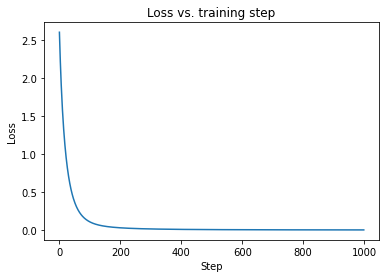

In [ ]:
W = nn.Parameter(torch.tensor([1.0, 2.0]), requires_grad=True)

# We create an optimizer, SGD (stochastic gradient descent)
# We tell it to optimize relative to W, with a learning rate of 0.01
optimizer = optim.SGD([W], lr=0.01)

history = []
for step in range(1000):
    # We zero out any gradients that may have been previously computed relative to W
    optimizer.zero_grad()

    # We call our loss function
    loss = f(W)

    history.append(loss.item())

    # We print the loss every 100th iteration
    if step % 100 == 0:
        print('Step {}: loss = {}'.format(step, loss.item()))

    # We compute gradients of the loss function, f, relative to W
    loss.backward()

    # We take a single step in the direction that minimizes the loss
    optimizer.step()

plt.plot(np.arange(len(history)), history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss vs. training step')
plt.show()

As you can see, the above code succesfully minimized $f$ relative to $W$.

## Part 3: Models

Now that you know how to create tensors, specify a function using these tensors, and optimize it relative to a set of parameters, the next step is to build a model and fit it. 

#### Neural Network Regression

Here, we'll train a create a neural network regressor that maps a 1-dimensional input $x$ to a 1-dimensional output $y$.

We'll use the following data-set:

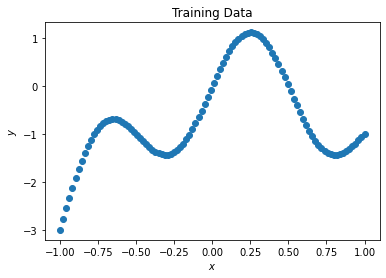

In [ ]:
X = torch.linspace(-1.0, 1.0, 100).unsqueeze(-1)
Y = torch.sin(X * 2.0 * np.pi) - 2.0 * torch.pow(X, 2.0) + X

plt.scatter(X.numpy(), Y.numpy())
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Training Data')
plt.show()

In PyTorch, one usually specifies a model by extending the `nn.Module` class, as follows:
```
class NeuralNetworkRegressor(nn.Module):
    def __init__(self):
        super(NeuralNetworkRegressor, self).__init__()

        # TODO create neural network

    def forward(self, x):
        # TODO implement forward-pass
```

In the constructor of this class (i.e. inside `__init__` ), we'll initialize the parameters of the neural network, and in `forward`, we'll use these parameters to transform an input $x$ into $y$. Recall that a neural network consists of a sequence of operations -- a linear transform, followed by some activation function (e.g. tanh), following by a linear operation, and so on depending on the depth of the network.

In [ ]:
class NeuralNetworkRegressor(nn.Module):
    def __init__(self):
        '''
        Creates a neural network with 2 hidden layers, each 20 units in size.
        It does this by creating the three linear transform that will be used.
        Each one of the nn.Linear objects below will automatically create the nn.Parameter objects
        necessary for the linear transform
        '''
        super(NeuralNetworkRegressor, self).__init__()

        
        self.layer1 = nn.Linear(1, 20) 
        self.layer2 = nn.Linear(20, 20) 
        self.layer3 = nn.Linear(20, 1) 

    def forward(self, x):
        '''
        Interleave the linear transforms with an activation function (in this case, tanh)
        '''
        h1 = torch.tanh(self.layer1(x))
        h2 = torch.tanh(self.layer2(h1))
        h3 = self.layer3(h2)
        return h3


# By creating and printing the model, we can see what nn.Parameter objects were created for it:
model = NeuralNetworkRegressor()
print(model)

NeuralNetworkRegressor(
  (layer1): Linear(in_features=1, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=1, bias=True)
)


Now that we created a PyTorch model, let's specify a loss function to train it. We'll create a loss function that penalizes the squared distance between the true labels and the predicted labels:
$$
\min_W \frac{1}{N} \sum\limits_{n=1}^N \left( y_n - \text{NeuralNetwork}(x_n; W) \right)^2
$$
where $N$ is the number of data points, $(x_n, y_n)$ is the $n$th observation, and $\text{NeuralNetwork}(x_n; W)$ refers to the prediction of the neural network at $x_n$. In PyToch, this looks like this:

In [ ]:
def loss_fn(model, X, Y):
    return torch.mean(torch.pow(Y - model.forward(X), 2.0))

Now that we have a model and loss function, we replicate the above code to optimize the loss function relative to the model's parameters (which we access via `model.parameters()`).

Step 0: loss = 1.5041602849960327
Step 1000: loss = 0.6629940867424011
Step 2000: loss = 0.4870884418487549
Step 3000: loss = 0.3275620937347412
Step 4000: loss = 0.21397840976715088
Step 5000: loss = 0.1664881706237793
Step 6000: loss = 0.142796590924263
Step 7000: loss = 0.1295752078294754
Step 8000: loss = 0.12109563499689102
Step 9000: loss = 0.11481686681509018
Step 10000: loss = 0.10961363464593887
Step 11000: loss = 0.1049644872546196
Step 12000: loss = 0.10060013085603714
Step 13000: loss = 0.09635215997695923
Step 14000: loss = 0.0920858383178711
Step 15000: loss = 0.0876724123954773
Step 16000: loss = 0.08298096060752869
Step 17000: loss = 0.07788305729627609
Step 18000: loss = 0.07226879894733429
Step 19000: loss = 0.06607133150100708
Step 20000: loss = 0.05930059030652046
Step 21000: loss = 0.052077516913414
Step 22000: loss = 0.04464726895093918
Step 23000: loss = 0.03734634444117546
Step 24000: loss = 0.03052857145667076
Step 25000: loss = 0.02448151633143425
Step 26000: 

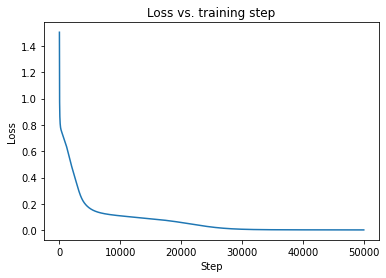

In [ ]:
model = NeuralNetworkRegressor()

# We create an optimizer, SGD (stochastic gradient descent)
# We tell it to optimize the loss function relative to the model's parameters
optimizer = optim.SGD(model.parameters(), lr=0.005)

history = []
for step in range(50000):
    # We zero out any gradients that may have been previously computed relative to W
    optimizer.zero_grad()

    # We call our loss function
    loss = loss_fn(model, X, Y)

    history.append(loss.item())

    # We print the loss every 1000th iteration
    if step % 1000 == 0:
        print('Step {}: loss = {}'.format(step, loss.item()))

    # We compute gradients of the loss function, f, relative to W
    loss.backward()

    # We take a single step in the direction that minimizes the loss
    optimizer.step()

plt.plot(np.arange(len(history)), history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss vs. training step')
plt.show()

As expected, the above loss function decreases with more iterations. Now, let's see how well our neural network fit the data:

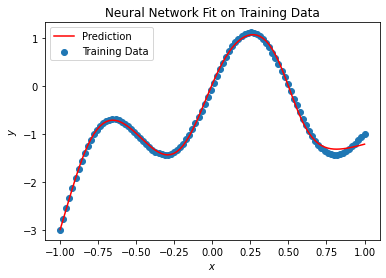

In [ ]:
plt.scatter(X.numpy(), Y.numpy(), label='Training Data')
plt.plot(X.numpy(), model(X).detach().numpy(), c='red', label='Prediction')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.title('Neural Network Fit on Training Data')
plt.legend()
plt.show()

**Note:** Since `model(X)` is a function of the `nn.Parameter` objects inside the `nn.Linear` objects, you'll need to detach it before you can convert it to numpy, as in the above code.

#### Neural Network Classifier

We'll now repeat the above process, but for classification. We'll start by creating our data-set:

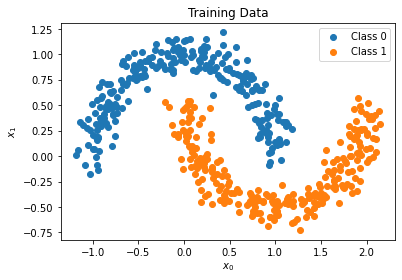

In [ ]:
# Sample the data-set
X, Y = sklearn.datasets.make_moons(n_samples=500, noise=0.1)

# Plot the data
plt.scatter(X[Y == 0][:, 0], X[Y == 0][:, 1], label='Class 0')
plt.scatter(X[Y == 1][:, 0], X[Y == 1][:, 1], label='Class 1')
plt.legend()
plt.xlabel('$x_0$')
plt.ylabel('$x_1$')
plt.title('Training Data')
plt.show()

# Convert the data to PyTorch's tensors
X = torch.tensor(X).float()
Y = torch.tensor(Y).unsqueeze(-1).float()

Now that we have our data-set, we'll define a classifier. This classifier object is identical to the above regressor object, with the exception of two things:
1. The first layer expects 2 dimensions as input, since in this data-set, our $x$'s are 2-dimensional.
2. The `forward` function requires an additional transform: the `sigmoid`. The sigmoid is a function that maps all real numbers to the interval $[0, 1]$. While in regression, $y$ can take on any real number, in binary classifiaction, $y$ can be either $0$ or $1$. We therefore use the sigmoid to output the *probability* that $y$ is $1$. 

In [ ]:
class NeuralNetworkBinaryClassifier(nn.Module):
    def __init__(self):
        '''
        Creates a neural network with 2 hidden layers, each 20 units in size.
        It does this by creating the three linear transform that will be used.
        Each one of the nn.Linear objects below will automatically create the nn.Parameter objects
        necessary for the linear transform.
        '''
        super(NeuralNetworkBinaryClassifier, self).__init__()

        
        self.layer1 = nn.Linear(2, 20) 
        self.layer2 = nn.Linear(20, 20) 
        self.layer3 = nn.Linear(20, 1) 

    def forward(self, x):
        '''
        Interleave the linear transforms with an activation function (in this case, tanh)
        '''
        h1 = torch.tanh(self.layer1(x))
        h2 = torch.tanh(self.layer2(h1))
        h3 = self.layer3(h2)

        # In contrast to the NeuralNetworkRegressor, we take 'h3' and feed it through a 
        # "sigmoid" transform, to make sure the output is a probability between 0 and 1
        return torch.sigmoid(h3)


# By creating and printing the model, we can see what nn.Parameter objects were created for it:
model = NeuralNetworkBinaryClassifier()
print(model)

NeuralNetworkBinaryClassifier(
  (layer1): Linear(in_features=2, out_features=20, bias=True)
  (layer2): Linear(in_features=20, out_features=20, bias=True)
  (layer3): Linear(in_features=20, out_features=1, bias=True)
)


Once we have the model, we define our loss and write the optimization loop. In contrast to the above example, in which we defined our own loss function, in this case we'll use one of PyTorch's defaults. Specifically, we'll use the `BCELoss` object to create the "Binary Cross Entropy" loss, which is the standard loss function used for binary classification.

Step 0: loss = 0.6620727777481079
Step 1000: loss = 0.3501853942871094
Step 2000: loss = 0.28642722964286804
Step 3000: loss = 0.26642563939094543
Step 4000: loss = 0.25754502415657043
Step 5000: loss = 0.2494887262582779
Step 6000: loss = 0.23925143480300903
Step 7000: loss = 0.22522862255573273
Step 8000: loss = 0.2060891091823578
Step 9000: loss = 0.18134528398513794
Step 10000: loss = 0.15250921249389648
Step 11000: loss = 0.12326869368553162
Step 12000: loss = 0.09757544845342636
Step 13000: loss = 0.07735297828912735
Step 14000: loss = 0.06232604384422302
Step 15000: loss = 0.051307305693626404
Step 16000: loss = 0.04313691332936287
Step 17000: loss = 0.03695226460695267
Step 18000: loss = 0.0321640819311142
Step 19000: loss = 0.028376907110214233
Step 20000: loss = 0.02532312087714672
Step 21000: loss = 0.022818319499492645
Step 22000: loss = 0.020732790231704712
Step 23000: loss = 0.018973372876644135
Step 24000: loss = 0.017471738159656525
Step 25000: loss = 0.0161769706755876

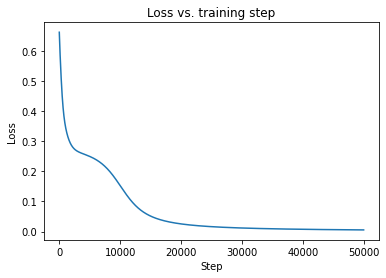

In [ ]:
loss_fn = nn.BCELoss()

model = NeuralNetworkBinaryClassifier()

# We create an optimizer, SGD (stochastic gradient descent)
# We tell it to optimize the loss function relative to the model's parameters
optimizer = optim.SGD(model.parameters(), lr=0.005)

history = []
for step in range(50000):
    # We zero out any gradients that may have been previously computed relative to W
    optimizer.zero_grad()

    # We call our loss function
    Y_pred = model.forward(X)
    loss = loss_fn(Y_pred, Y)

    history.append(loss.item())

    # We print the loss every 1000th iteration
    if step % 1000 == 0:
        print('Step {}: loss = {}'.format(step, loss.item()))

    # We compute gradients of the loss function, f, relative to W
    loss.backward()

    # We take a single step in the direction that minimizes the loss
    optimizer.step()

plt.plot(np.arange(len(history)), history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss vs. training step')
plt.show()

Lastly, we visualize the fit of our classifier on the data-set.

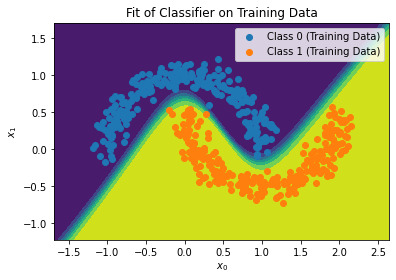

In [ ]:
@torch.no_grad()
def plot_decision_boundary(model, X, y):
    '''
    Adapted from: https://medium.com/@prudhvirajnitjsr/simple-classifier-using-pytorch-37fba175c25c
    '''

    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01

    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the function value for the whole gid
    Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()]).float()).numpy()
    Z = Z.reshape(xx.shape)

    # Plot the contour and training examples
    plt.contourf(xx, yy, Z)
    plt.scatter(X[y.squeeze() == 0][:, 0], X[y.squeeze() == 0][:, 1], label='Class 0 (Training Data)')
    plt.scatter(X[y.squeeze() == 1][:, 0], X[y.squeeze() == 1][:, 1], label='Class 1 (Training Data)')

    plt.xlabel('$x_0$')
    plt.ylabel('$x_1$')
    plt.title('Fit of Classifier on Training Data')

    plt.legend()
    plt.show()

plot_decision_boundary(model, X, Y)